In [3]:
# %load firstcell.txt
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
plt.rcParams['figure.dpi']=100

from functools import reduce

### Measures to compare:

+ Total imports value - tot_imp_vl
+ Total exports value - tot_exp_vl
+ Total imports quantity - tot_imp_qt
+ Total exports quantity - tot_exp_qt
+ Difference between total exports and total imports value - diff_exp_imp_vl
+ Difference between total exports and total imports quantity- diff_exp_imp_qt
+ Total Gross domestic product - tot_gdp
+ Total Population - tot_pop
+ Total export distance - dist_exp
+ Total import distance - dist_imp

In [4]:
# food trade data
df=pd.read_csv('united_names_datasets/tradeMatrix_PWG.csv')

In [5]:
df

,importer,exporter,Item,Element,Year,Unit,Value
0,Afghanistan,Argentina,Maize,Import Quantity,2017,tonnes,130.0
1,Afghanistan,Argentina,Maize,Import Value,2017,1000 US$,68.0
2,Afghanistan,Australia,Rice - total (Rice milled equivalent),Import Quantity,2010,tonnes,32.0
3,Afghanistan,Australia,Rice - total (Rice milled equivalent),Import Value,2010,1000 US$,21.0
4,Afghanistan,Azerbaijan,Rice - total (Rice milled equivalent),Import Quantity,2014,tonnes,16.0
...,...,...,...,...,...,...,...
632781,Zimbabwe,Zambia,Wheat,Import Value,1997,1000 US$,95.0
632782,Zimbabwe,Zambia,Wheat,Import Value,2009,1000 US$,3074.0
632783,Zimbabwe,Zambia,Wheat,Import Value,2010,1000 US$,1401.0
632784,Zimbabwe,Zambia,Wheat,Import Value,2013,1000 US$,1361.0


In [6]:
# Load antifragility values

# Not normalized
af = pd.read_csv('normalization/datasets_intersection/af_food_trade_mean.csv',index_col=0)

# Distance normalized
af_distances = pd.read_csv('normalization/distan_datasets/distances_af_percountry.csv',index_col=0)

# Caloric normalized
af_caloric = pd.read_csv('normalization/caloric_af_percountry.csv',index_col=0)

# GDP normalized and population normalized
af_gdp_pop= pd.read_csv('normalization/datasets_intersection/gdp_pop_af_food_trade_percountry.csv',index_col=0)

af_gdp = af_gdp_pop.iloc[:,:8]

af_pop = af_gdp_pop.iloc[:,8:]

dict_afs = {'af':af,'af_distances':af_distances,'af_caloric':af_caloric,'af_gdp':af_gdp,'af_pop':af_pop}

In [8]:
af_gdp.shape

(222, 8)

In [7]:
#### Total imports value - tot_imp_v
tot_imp_vl=df[df.Element=='Import Value'].groupby('importer')['Value'].sum() # compute total imports value

#### Total exports value - tot_exp_vl
tot_exp_vl = df[df.Element=='Import Value'].groupby('exporter')['Value'].sum() # compute total exports value

#### Total imports quantity - tot_imp_qt
tot_imp_qt = df[df.Element=='Import Quantity'].groupby('importer')['Value'].sum()

#### Total exports quantity - tot_exp_qt
tot_exp_qt = df[df.Element=='Import Quantity'].groupby('exporter')['Value'].sum()

#### Difference between total exports and total imports value - diff_exp_imp_vl
diff_exp_imp_vl = tot_exp_vl-tot_imp_vl

#### Difference between total exports and total imports quantity- diff_exp_imp_qt
diff_exp_imp_qt = tot_exp_qt-tot_imp_qt

#### Total Gross domestic product - tot_gdp
gdp = pd.read_csv('normalization/GDP_filtered.csv',index_col=0)
tot_gdp = gdp.groupby('country.value').sum()['value']

#### Total Population - tot_pop
pop = pd.read_csv('normalization/Population_filtered.csv',index_col=0)
tot_pop = pop.groupby('country.value').sum()['value']

#### Total export distance - dist_exp
distances=pd.read_csv('normalization/distan_datasets/distances_YEI.csv',index_col=0)
dist_exp = distances.groupby('exporter').sum()['distance']

#### Total import distance - dist_imp
dist_imp = distances.groupby('importer').sum()['distance']

measures={'tot_imp_vl':tot_imp_vl,'tot_exp_vl':tot_exp_vl,'tot_imp_qt':tot_imp_qt,
          'tot_exp_qt':tot_exp_qt,'diff_exp_imp_vl':diff_exp_imp_vl,'diff_exp_imp_qt':diff_exp_imp_qt,
         'tot_gdp':tot_gdp,'tot_pop':tot_pop,'dist_exp':dist_exp,'dist_imp':dist_imp}

In [10]:
afs_measures={}

for af_name,af_case in dict_afs.items():

    to_merge=[] 
    for measure_name,measure_frame in measures.items():
        # format the af dataframe to merge it
        format_af=af_case.loc[measure_frame.index.values].reset_index().rename(columns={'index':'country'}) 
        format_af=format_af.melt(id_vars=['country'],value_name='af_value',var_name='af_case')

        # format the measure pandas series to merge them
        measure_formatted=measure_frame.reset_index().rename(columns={measure_frame.reset_index().columns[0]:'country'})
        measure_formatted=measure_formatted.rename(columns={measure_formatted.columns[1]:measure_name})
        to_merge.append(measure_formatted)

    # Append the formatted af dataframe at the beginning of the list
    to_merge.insert(0,format_af)
    # merge from left to right each element of to_merge list
    merged_af_measure=reduce(lambda left,right:pd.merge(left,right,on='country') ,to_merge)
    merged_af_measure=merged_af_measure.melt(id_vars=['country','af_case','af_value'],value_name='measure')
    
    afs_measures[af_name] = merged_af_measure

/home/emmanuel/miniconda3/envs/toughenv/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


In [13]:
to_melt_avg=[afs_measures['af'].groupby(['country','variable']).mean().reset_index().rename(columns={'af_value':'avg_af'})]

for af_name,af_case in afs_measures.items(): 
    if af_name != 'af':
        avg_af_tomelt=af_case.groupby(['country','variable']).mean().reset_index().loc[:,['country','variable','af_value']]    
        avg_af_tomelt=avg_af_tomelt.rename(columns={'af_value':'avg_'+af_name})
        to_melt_avg.append(avg_af_tomelt)
    else:
        continue
        
avg_AFmeasure_melted=reduce(lambda left,right: pd.merge(left,right,on=['country','variable']),to_melt_avg).rename(columns={'variable':'measure_name'})
avg_af_measure=avg_AFmeasure_melted.melt(id_vars=['country','measure_name','measure'])

In [24]:
avg_af_measure

,country,measure_name,measure,variable,value
0,Afghanistan,diff_exp_imp_qt,-4.259392e+06,avg_af,-0.015653
1,Afghanistan,diff_exp_imp_vl,-1.426495e+06,avg_af,-0.015653
2,Afghanistan,dist_exp,5.110929e+05,avg_af,-0.015653
3,Afghanistan,dist_imp,3.639157e+05,avg_af,-0.015653
4,Afghanistan,tot_exp_qt,5.473300e+05,avg_af,-0.015653
...,...,...,...,...,...
7595,Zimbabwe,tot_exp_vl,4.981420e+05,avg_af_pop,-0.002393
7596,Zimbabwe,tot_gdp,3.104579e+11,avg_af_pop,-0.002393
7597,Zimbabwe,tot_imp_qt,1.410648e+07,avg_af_pop,-0.002393
7598,Zimbabwe,tot_imp_vl,5.174759e+06,avg_af_pop,-0.002393


In [18]:
plt.style.use('dark_background')

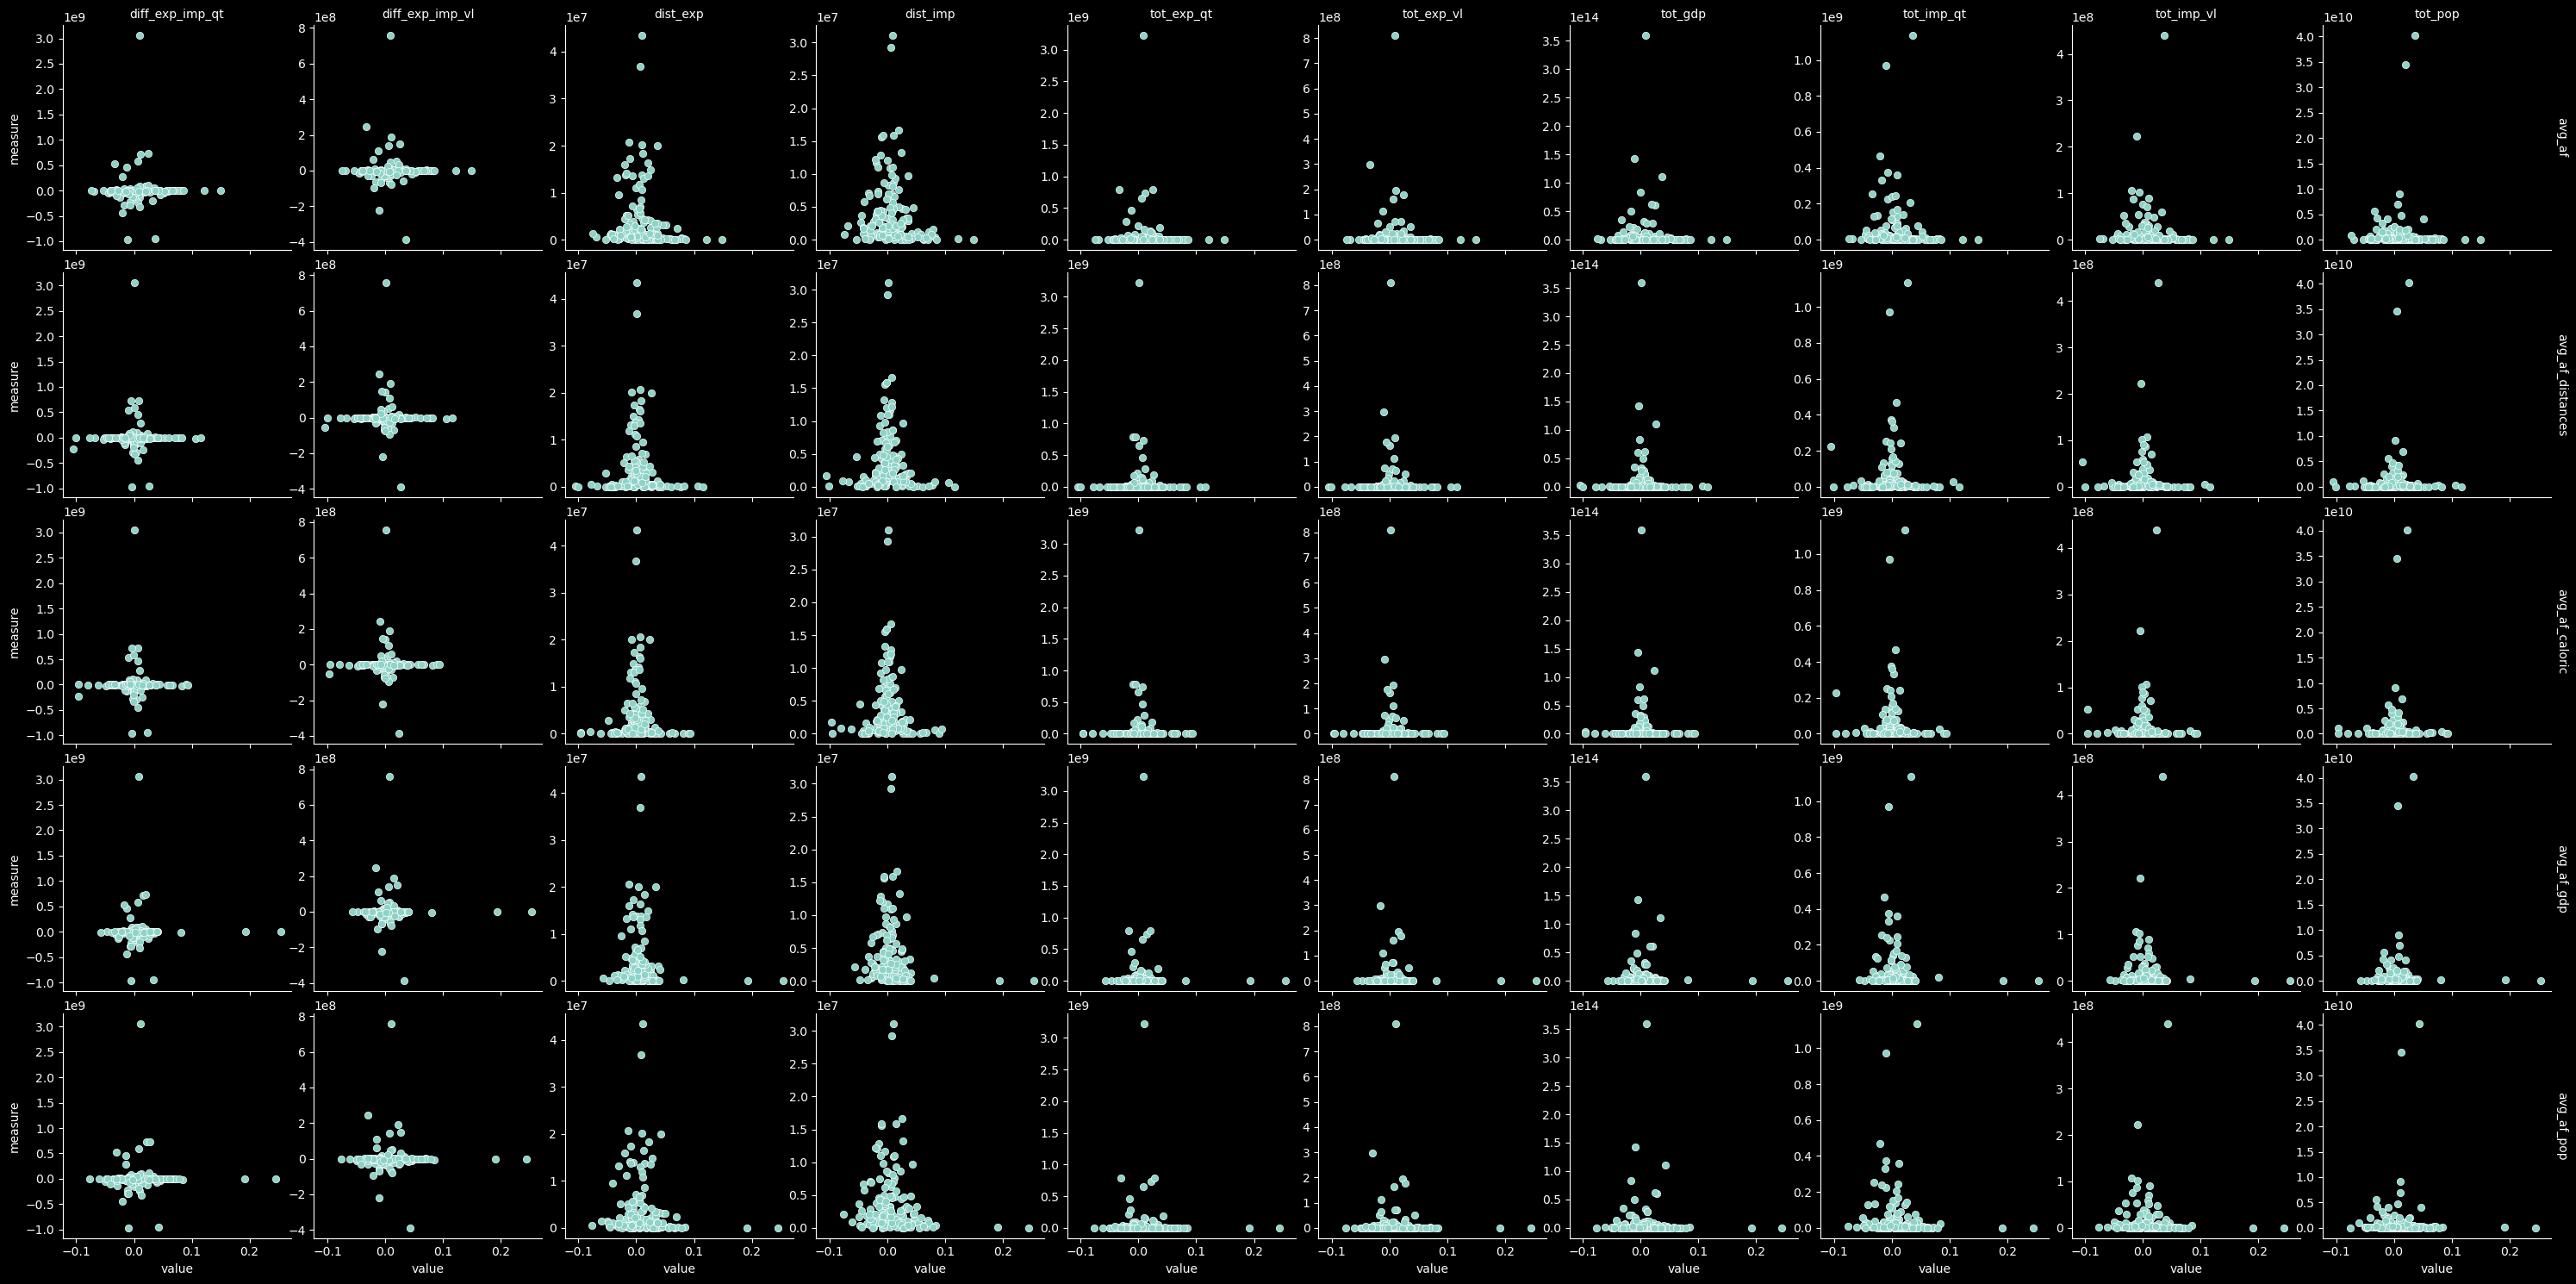

In [19]:
g=sns.FacetGrid(avg_af_measure,col='measure_name',row='variable',margin_titles=True,sharey=False)
g.map(sns.scatterplot,'value','measure')
g.fig.subplots_adjust(wspace=.1, hspace=.1)
g.set_titles(col_template="{col_name}", row_template="{row_name}")

In [ ]:
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

### NOTA:
####  Las altas correlaciones entre algunos de los distintos casos de antifragilidad en el scatterplot matrix siguiere que son redundantes y deberiamos usar uno solo de ellos.

In [178]:
for afname,af in dict_afs.items():
    
    sns.set(style='white', font_scale=1.6)
    g = sns.PairGrid(af.dropna(), aspect=1.4, diag_sharey=False)
    g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
    g.map_diag(sns.distplot, kde_kws={'color': 'black'})
    g.map_upper(corrdot)
    plt.savefig(f'exploratory_plots/AFS/{afname}.png')
    plt.close()

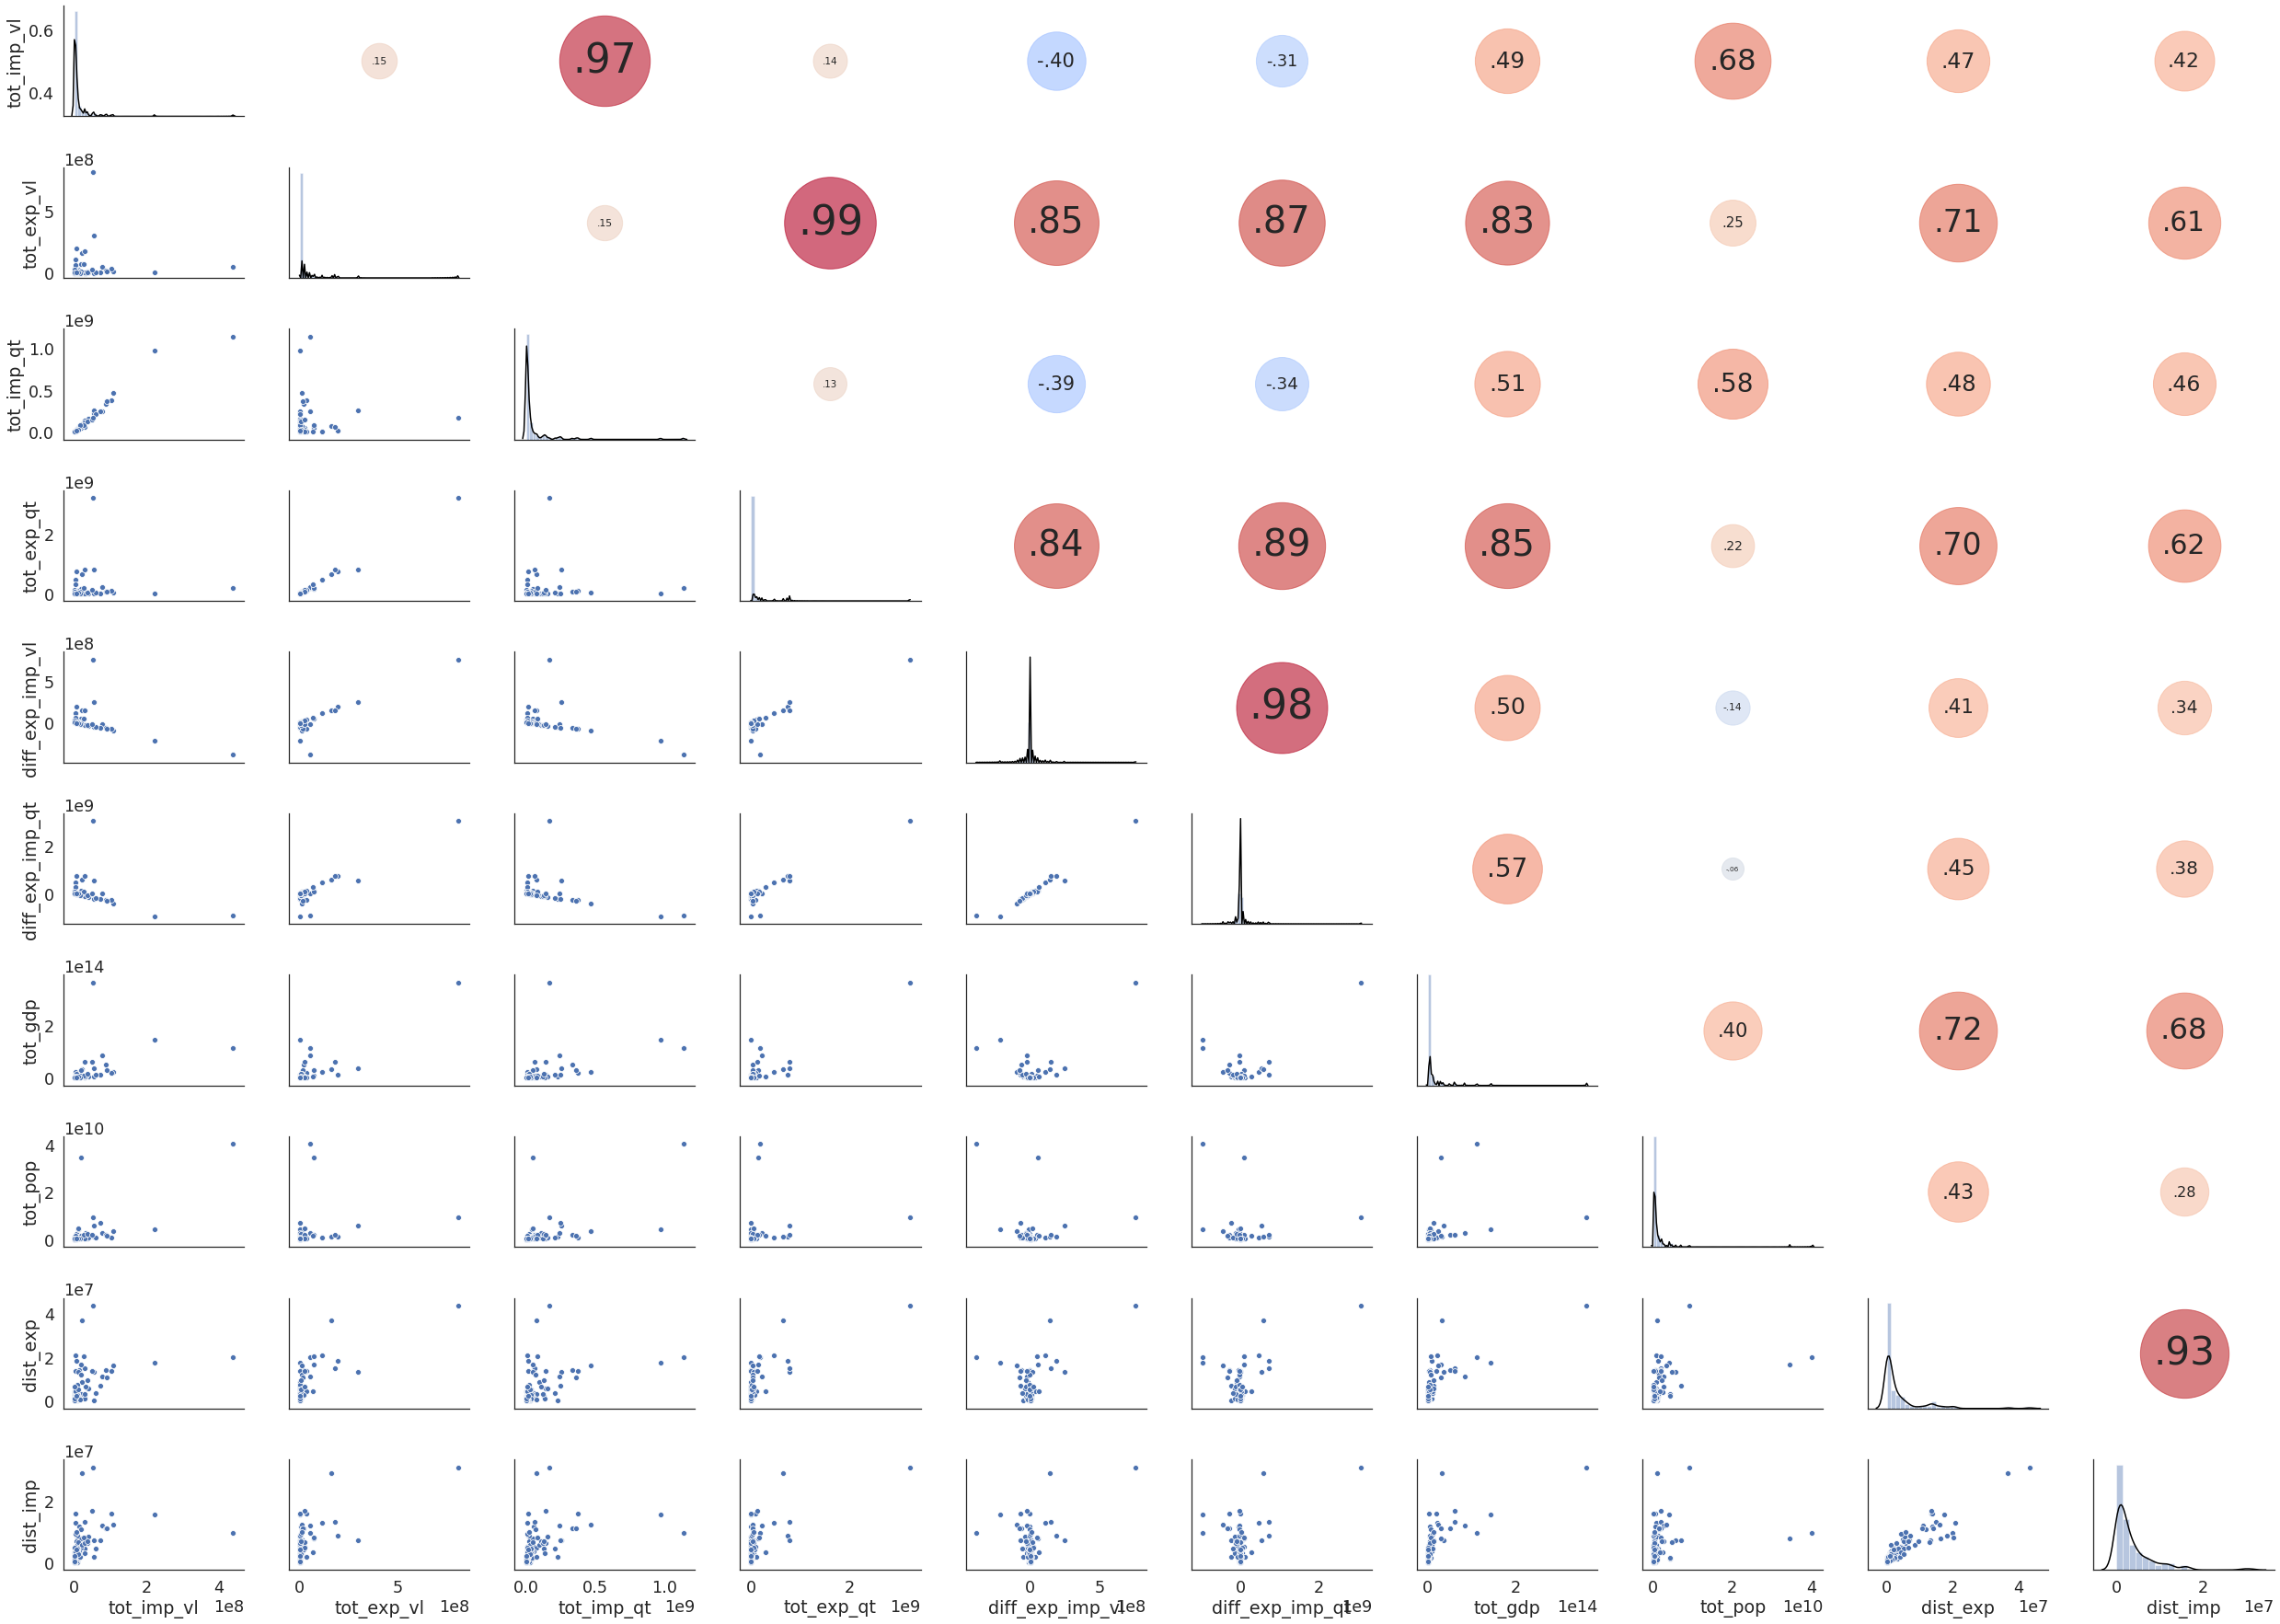

In [325]:
toconcat_measures=[]
for measure_name,measure_case in measures.items():
    toconcat_measures.append(measure_case.to_frame(measure_name))
concatenated_measures=pd.concat(toconcat_measures,axis=1,sort=False)


sns.set(style='white', font_scale=1.6)
g = sns.PairGrid(concatenated_measures.dropna(), aspect=1.4, diag_sharey=False)
g.map_lower(sns.scatterplot)
g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)
# plt.savefig(f'exploratory_plots/MEASURES/{measure_name}.png')
# plt.close()